In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/divl/ACV_final/data/')

Mounted at /content/drive


# wake detection

In [17]:
import numpy as np
import cv2, os, csv

def wake_detection(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_channel, s_channel, v_channel = cv2.split(img_hsv)
    kernel_size = 15
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    # Apply Top-hat and CLAHE to v_channel
    v_tophat = cv2.morphologyEx(v_channel, cv2.MORPH_TOPHAT, kernel)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_channel_clahe = clahe.apply(v_tophat)

    # binarize mask and combine
    _, sat_mask = cv2.threshold(s_channel, 100, 255, cv2.THRESH_BINARY_INV)
    _, val_mask_after = cv2.threshold(v_channel_clahe, 50, 255, cv2.THRESH_BINARY)
    _, val_mask_before = cv2.threshold(v_channel, 170, 255, cv2.THRESH_BINARY)

    combined_mask_v = cv2.bitwise_and(val_mask_after, val_mask_before)
    final_combined_mask = cv2.bitwise_and(sat_mask, combined_mask_v)

    # morphology setting
    dilated_kernel_size = 3 # You can change this to 5, 7, etc.
    dilated_kernel = np.ones((dilated_kernel_size, dilated_kernel_size), np.uint8)

    eroded_kernel_size = 7 # You can change this to 5, 7, etc.
    eroded_kernel = np.ones((eroded_kernel_size, eroded_kernel_size), np.uint8)

    # Apply dilation and erosion
    iterations = 2
    mor_mask = cv2.dilate(final_combined_mask, dilated_kernel, iterations=iterations)
    # mor_mask = cv2.erode(mor_mask, eroded_kernel, iterations=1)

    # filter noise out
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mor_mask, 8, cv2.CV_32S)
    areas = [stats[i, cv2.CC_STAT_AREA] for i in range(1, num_labels)]

    if areas:
        max_area = max(areas)
    else:
        max_area = 0

    area_threshold = 0.15 * max_area # 10% of the largest area
    filtered_mask = np.zeros(labels.shape, dtype="uint8")

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= area_threshold:
            filtered_mask[labels == i] = 255
    return filtered_mask

In [3]:
import cv2
import numpy as np

def calculate_oriented_iou(rect1, rect2):
    """
    Calculates the Intersection over Union (IoU) of two rotated bounding boxes.

    Args:
        rect1 (tuple): First rotated bounding box ((center_x, center_y), (width, height), angle).
        rect2 (tuple): Second rotated bounding box ((center_x, center_y), (width, height), angle).

    Returns:
        float: The IoU value.
    """
    # Calculate intersection of the two rotated rectangles
    intersection_type, intersection_polygon_points = cv2.rotatedRectangleIntersection(rect1, rect2)

    intersection_area = 0.0

    # If there is an intersection, calculate its area
    if intersection_type != cv2.INTERSECT_NONE:
        # Convert intersection points to a NumPy array for cv2.contourArea
        if intersection_polygon_points is not None:
            intersection_polygon_points_np = np.array(intersection_polygon_points, dtype=np.float32)
            intersection_area = cv2.contourArea(intersection_polygon_points_np)

    # Calculate areas of rect1 and rect2
    area_rect1 = rect1[1][0] * rect1[1][1]
    area_rect2 = rect2[1][0] * rect2[1][1]

    # Calculate union area
    union_area = area_rect1 + area_rect2 - intersection_area

    # Calculate IoU, handle division by zero
    if union_area == 0:
        iou = 0.0
    else:
        iou = intersection_area / union_area

    return iou

In [4]:
import numpy as np
import cv2, os, csv
import matplotlib.pyplot as plt
import numpy as np

def bbox(img, mask, gt_file_path):
  gt_oriented_bboxes = []

  # Read the GT file and parse oriented bounding box coordinates
  try:
      with open(gt_file_path, 'r') as f:
          for line in f:
              # Clean the line: remove brackets and commas, then split by whitespace
              cleaned_line = line.strip().replace('[', '').replace(']', '').replace(',', '')
              parts = list(map(int, cleaned_line.split()))

              # Check if there are 8 parts (4 x,y coordinate pairs)
              if len(parts) == 8:
                  # Append the 8 coordinates directly as an oriented bounding box
                  gt_oriented_bboxes.append(parts)
              else:
                  print(f"Warning: Skipping malformed line in {gt_file_path}: {line.strip()}")
  except FileNotFoundError:
      print(f"Error: Ground Truth file not found at {gt_file_path}")
  except Exception as e:
      print(f"An error occurred while reading the GT file: {e}")

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  detected_oriented_bboxes = []

  for contour in contours:
    rect = cv2.minAreaRect(contour)
    detected_oriented_bboxes.append(rect)
  for i, bbox in enumerate(detected_oriented_bboxes):
    center, size, angle = bbox

  image_with_oriented_bboxes = np.copy(img)

  detected_bbox_color = (255, 0, 0)
  gt_bbox_color = (0, 255, 0)
  text_color = (255, 255, 0)

  detected_bbox_color_bgr = (detected_bbox_color[2], detected_bbox_color[1], detected_bbox_color[0]) # (0, 0, 255)
  gt_bbox_color_bgr = (gt_bbox_color[2], gt_bbox_color[1], gt_bbox_color[0]) # (0, 255, 0)
  text_color_bgr = (text_color[2], text_color[1], text_color[0]) # (0, 255, 255)

  all_best_ious = [] # Initialize a list to store all best IoU values for detected bboxes

  print("\n--- Detected Oriented BBoxes IoU Results ---")
  for i, det_rect_tuple in enumerate(detected_oriented_bboxes):
      best_iou_for_det = 0.0
      best_gt_oriented_bbox_match = None

      # b. Iterate through each Ground Truth oriented bounding box
      for gt_bbox_coords in gt_oriented_bboxes:
          # a. Ground Truth bounding box (8 points) needs to be converted to ((center_x, center_y), (width, height), angle) format
          # to be compatible with calculate_oriented_iou and cv2.boxPoints.
          # We find the minAreaRect of the 4 GT points.
          gt_points = np.array([[gt_bbox_coords[0], gt_bbox_coords[1]],
                                [gt_bbox_coords[2], gt_bbox_coords[3]],
                                [gt_bbox_coords[4], gt_bbox_coords[5]],
                                [gt_bbox_coords[6], gt_bbox_coords[7]]], dtype=np.int32)
          gt_rect_tuple = cv2.minAreaRect(gt_points)

          # c. Calculate IoU
          iou = calculate_oriented_iou(det_rect_tuple, gt_rect_tuple)

          # d. Update best IoU if current IoU is greater
          if iou > best_iou_for_det:
              best_iou_for_det = iou
              best_gt_oriented_bbox_match = gt_bbox_coords # Store the original 8-coord GT for reference

      # Add the best IoU for the current detected bbox to the list
      all_best_ious.append(best_iou_for_det)

        # e. Draw the current detected bbox (red)
      det_points = cv2.boxPoints(det_rect_tuple)
      det_points = det_points.astype(int) # Convert to integer coordinates
      cv2.polylines(image_with_oriented_bboxes, [det_points], True, detected_bbox_color_bgr, 2)

      # f. Annotate with best IoU value
      if best_iou_for_det > 0:
          center_x, center_y = det_rect_tuple[0]
          # Adjust text position to be near the box
          text_x = int(center_x) - 30
          text_y = int(center_y) - 30 if int(center_y) - 30 > 10 else int(center_y) + 30
          cv2.putText(image_with_oriented_bboxes, f'IoU: {best_iou_for_det:.2f}', (text_x, text_y),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color_bgr, 1, cv2.LINE_AA)

      # g. Print the detected bbox and its best IoU
      center, size, angle = det_rect_tuple
      print(f"Detected BBox {i+1} (Center=({center[0]:.2f}, {center[1]:.2f}), Size=({size[0]:.2f}, {size[1]:.2f}), Angle={angle:.2f}) - Best IoU: {best_iou_for_det:.4f})")

  # Calculate and print the average IoU for the image
  if all_best_ious:
      average_iou = sum(all_best_ious) / len(all_best_ious)
      print(f"\nAverage IoU for the image: {average_iou:.4f}")
  else:
      print("\nNo detected bounding boxes to calculate average IoU.")


  # 5. Draw all Ground Truth oriented bounding boxes (green)
  print("\n--- Ground Truth Oriented BBoxes ---")
  for i, gt_bbox_coords in enumerate(gt_oriented_bboxes):
      # a. Ground Truth bounding box (8 points) needs to be converted to ((center_x, center_y), (width, height), angle) format
      gt_points = np.array([[gt_bbox_coords[0], gt_bbox_coords[1]],
                            [gt_bbox_coords[2], gt_bbox_coords[3]],
                            [gt_bbox_coords[4], gt_bbox_coords[5]],
                            [gt_bbox_coords[6], gt_bbox_coords[7]]], dtype=np.int32)
      gt_rect_tuple = cv2.minAreaRect(gt_points)
      gt_box_points = cv2.boxPoints(gt_rect_tuple)
      gt_box_points = gt_box_points.astype(int) # Convert to integer coordinates
      cv2.polylines(image_with_oriented_bboxes, [gt_box_points], True, gt_bbox_color_bgr, 2)

  return image_with_oriented_bboxes


--- Detected Oriented BBoxes IoU Results ---
Detected BBox 1 (Center=(635.63, 583.67), Size=(1273.17, 263.56), Angle=0.58) - Best IoU: 0.1283)

Average IoU for the image: 0.1283

--- Ground Truth Oriented BBoxes ---
detection duraion: 0.024205923080444336
annotation duraion: 0.5318624973297119


(np.float64(-0.5), np.float64(1273.5), np.float64(715.5), np.float64(-0.5))

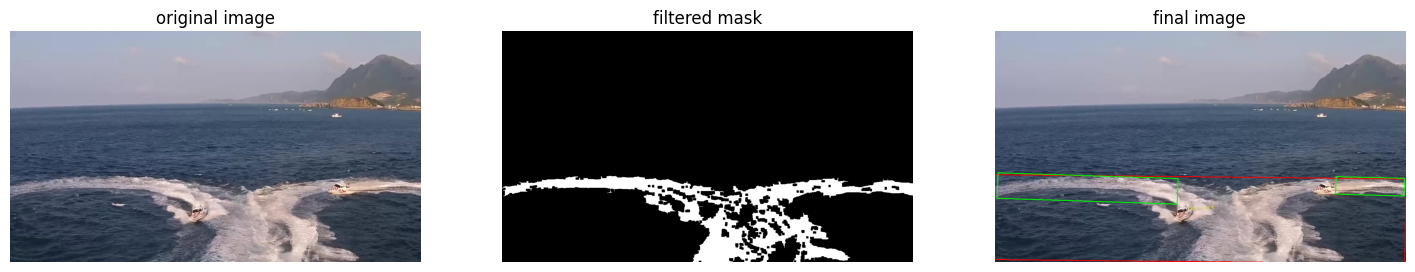

In [16]:
import matplotlib.pyplot as plt
import time

image_folder = "./photo/"
gt_folder = "./GT/"
save_folder = "./results/"
image_path = os.path.join(image_folder, 'c2.jpg')
img = cv2.imread(image_path)
gt_file_path = os.path.join(gt_folder, 'c2.txt')
save_pth_img = os.path.join(save_folder, 'c2.jpg')
save_pth_mask = os.path.join(save_folder, 'c2_mask.jpg')

t0 = time.time()
mask = wake_detection(img)
t1 = time.time()
bbox_img = bbox(img, mask, gt_file_path)
t2 = time.time()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bbox_img_rgb = cv2.cvtColor(bbox_img, cv2.COLOR_BGR2RGB)

# Save the bounding box image in RGB format to match display
cv2.imwrite(save_pth_img, bbox_img)
cv2.imwrite(save_pth_mask, mask)

print(f"detection duraion: {t1-t0}")
print(f"annotation duraion: {t2-t1}")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('original image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('filtered mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bbox_img_rgb)
plt.title('final image')
plt.axis('off')

## results table
## setting1
- sat threshold=100, inv
- val_after threshold=50
- val_before threshold=150
- morphology dilation k=3, iter=3
- morphology erotion k=7, iter=1
- noise thresshold=0.10
- img | processing time | annotation time | IOU\
a1 | 0.010|0.007|0.50\
a2 | 0.008|0.006|0.49\
a3 | 0.030|0.006|0.33\
b1 | 0.008|0.008|0.45\
b2 | 0.022|0.008|0.07\
b3 | 0.040|0.009|0.16\
c1 | 0.029|0.006|0.03\
c2 | 0.023|0.005|0.13\
c3 | 0.019|0.008|0.03

## setting2
- sat threshold=100, inv
- val_after threshold=50
- val_before threshold=170
- morphology dilation k=3, iter=2
- noise thresshold=0.10
- img | processing time | annotation time | IOU\
a1 | 0.010|0.007|0.31\
a2 | 0.008|0.006|0.31\
a3 | 0.030|0.006|0.28\
b1 | 0.008|0.008|0.41\
b2 | 0.022|0.008|0.10\
b3 | 0.040|0.009|0.17\
c1 | 0.029|0.006|0.12\
c2 | 0.023|0.005|0.22\
c3 | 0.019|0.008|0.00


# tracking processing



In [ ]:
def get_component_properties(mask):
    """
    Finds contours, calculates centroids, and determines cv2.minAreaRect for each
    connected component in a binary mask.

    Args:
        mask (numpy.ndarray): A binary mask image.

    Returns:
        list: A list of dictionaries, where each dictionary contains the 'centroid'
              as a tuple (center_x, center_y) and the 'min_area_rect' tuple
              ((center_x, center_y), (width, height), angle) for each component.
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    component_properties = []

    for contour in contours:
        # Ensure the contour has enough points to calculate minAreaRect (at least 5 points)
        if len(contour) >= 5:
            min_area_rect = cv2.minAreaRect(contour)

            # Calculate moments for centroid
            M = cv2.moments(contour)

            centroid = None
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
                centroid = (center_x, center_y)

            if centroid is not None:
                component_properties.append({
                    'centroid': centroid,
                    'min_area_rect': min_area_rect
                })
    return component_properties

print("Function `get_component_properties` defined.")

Function `get_component_properties` defined.


In [ ]:
def get_forward_vectors(current_frame, next_frame):
    """
    Detects wakes, extracts component properties, matches components between
    consecutive frames, and calculates forward vectors.

    Args:
        current_frame (numpy.ndarray): The current video frame.
        next_frame (numpy.ndarray): The next video frame.

    Returns:
        list: A list of tuples, where each tuple contains (object_id, start_point, end_point)
              for all calculated forward vectors.
    """
    # 1. Apply wake detection to both frames
    current_mask = wake_detection(current_frame)
    next_mask = wake_detection(next_frame)

    # 2. Extract component properties for both masks
    current_frame_components = get_component_properties(current_mask)
    next_frame_components = get_component_properties(next_mask)

    forward_vectors = []
    object_id_counter = 1 # Sequential ID for tracked objects within this frame pair
    matching_threshold = 100 # Example threshold in pixels, can be tuned based on object movement

    # Keep track of next_frame components that have already been matched
    matched_next_components_indices = set()

    # 3. Implement component matching logic
    for current_comp in current_frame_components:
        current_centroid = current_comp['centroid']
        min_distance = float('inf')
        best_match_index = -1

        for i, next_comp in enumerate(next_frame_components):
            # Skip components in the next frame that have already been matched to a different current_comp
            if i in matched_next_components_indices:
                continue

            next_centroid = next_comp['centroid']

            # Calculate Euclidean distance between centroids
            distance = np.linalg.norm(np.array(current_centroid) - np.array(next_centroid))

            # If distance is within threshold and better than previous best
            if distance < min_distance and distance < matching_threshold:
                min_distance = distance
                best_match_index = i

        # 4. If a match is found, calculate the forward vector
        if best_match_index != -1:
            # Mark the next_frame component as matched
            matched_next_components_indices.add(best_match_index)

            matched_next_centroid = next_frame_components[best_match_index]['centroid']

            # NEW LOGIC START
            # 1. Retrieve the min_area_rect of the current_comp.
            # Extract center, size (width, height), and angle from min_area_rect
            (cx, cy), (width, height), angle = current_comp['min_area_rect']

            # Determine wake_length and angle_rad of the principal (longer) axis
            if width >= height:
                wake_length = width
                angle_rad = np.radians(angle)
            else:
                wake_length = height
                # If height is longer, the angle is rotated by 90 degrees relative to width
                # The angle from minAreaRect is usually for the longer side or closest to 0/90 degrees.
                # We want the angle of the *principal axis*, so add 90 if height is the longer side.
                angle_rad = np.radians(angle + 90)

            # Calculate half_wake_length
            half_wake_length = wake_length / 2

            # Compute dx and dy components along the principal axis
            dx = half_wake_length * np.cos(angle_rad)
            dy = half_wake_length * np.sin(angle_rad)

            # Derive extreme_point1_float and extreme_point2_float
            extreme_point1_float = (cx - dx, cy - dy)
            extreme_point2_float = (cx + dx, cy + dy)

            # Convert to integer tuples
            extreme_point1 = (int(round(extreme_point1_float[0])), int(round(extreme_point1_float[1])))
            extreme_point2 = (int(round(extreme_point2_float[0])), int(round(extreme_point2_float[1])))
            # NEW LOGIC END

            # Determine which extreme point is closer to matched_next_centroid
            dist_to_centroid1 = np.linalg.norm(np.array(extreme_point1) - np.array(matched_next_centroid))
            dist_to_centroid2 = np.linalg.norm(np.array(extreme_point2) - np.array(matched_next_centroid))

            if dist_to_centroid1 < dist_to_centroid2:
                end_point = tuple(extreme_point1)
                start_point = tuple(extreme_point2)
            else:
                end_point = tuple(extreme_point2)
                start_point = tuple(extreme_point1)

            # 5. Add to forward_vectors with object_id, start_point, end_point
            forward_vectors.append((object_id_counter, start_point, end_point))
            object_id_counter += 1

    return forward_vectors

print("Function `get_forward_vectors` defined.")

Function `get_forward_vectors` defined.


In [ ]:
def video_processing(cap, video_results_folder, video_name, video):
  tracking_results = []
  frame_count = 0

  # build video writer
  video_path = os.path.join(video_results_folder, video)
  fps = cap.get(cv2.CAP_PROP_FPS)
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

  ret, prev_frame = cap.read()

  if not ret:
      print("Error: Could not read the first frame.")
  else:
      print("Starting video processing...")
      while True:
          ret, current_frame = cap.read()
          if not ret:
              break # End of video

          # Get forward vectors between previous and current frame
          # Note: The problem description implies tracking from current to next frame,
          # so 'prev_frame' is the 'current_frame' for the get_forward_vectors logic,
          # and 'current_frame' is the 'next_frame'.
          forward_vectors = get_forward_vectors(prev_frame, current_frame)
          frame_to_vis = prev_frame.copy()

          for obj_id, start_point, end_point in forward_vectors:
              tracking_results.append({
                  'frame_number': frame_count,
                  'object_id': obj_id,
                  'start_point': start_point,
                  'end_point': end_point
              })
              # draw on prev_frame
              cv2.line(frame_to_vis, start_point, end_point, (0, 255, 0), 5)

          video_writer.write(frame_to_vis)
          # Update prev_frame for the next iteration
          prev_frame = current_frame
          frame_count += 1

  cap.release()

  # Save tracking results to d1.txt
  output_file_path = os.path.join(video_results_folder, video_name)
  with open(output_file_path, 'w') as f:
      for result in tracking_results:
          f.write(f"Frame: {result['frame_number']}, Object ID: {result['object_id']}, Start: {result['start_point']}, End: {result['end_point']}\n")

  print(f"Processed {frame_count} frames. Tracking results saved to {output_file_path}")

# angle function

In [ ]:
def calculate_vector_angle(start_point, end_point):
    """
    Calculates the angle of a vector with respect to the positive x-axis.

    Args:
        start_point (tuple): The (x, y) coordinates of the vector's starting point.
        end_point (tuple): The (x, y) coordinates of the vector's ending point.

    Returns:
        float: The angle of the vector in degrees, relative to the positive x-axis.
    """
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]

    # Calculate the angle in radians using arctan2, which handles all quadrants
    angle_radians = np.arctan2(delta_y, delta_x)

    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

print("Function `calculate_vector_angle` defined.")

Function `calculate_vector_angle` defined.


In [ ]:
def calculate_angle_difference(angle1, angle2):
    """
    Calculates the absolute difference between two angles in degrees,
    ensuring the result is always between 0 and 180 degrees.

    Args:
        angle1 (float): The first angle in degrees.
        angle2 (float): The second angle in degrees.

    Returns:
        float: The absolute angular difference between 0 and 180 degrees.
    """
    # Calculate the raw difference
    diff = abs(angle1 - angle2)

    # Ensure the result is between 0 and 180 degrees
    # The angular difference should always be the shortest path, so it can't exceed 180.
    # For example, difference between 10 and 350 is 20 (not 340).
    return min(diff, 360 - diff)

print("Function `calculate_angle_difference` defined.")

Function `calculate_angle_difference` defined.


In [ ]:
import re
import os

def parse_gt_data(file_path):
    """
    解析格式如下的 GT 檔案:
    1
    1 [510, 326] [495, 303]
    2 [570, 424] [558, 407]
    ...
    2
    1 [504, 322] [493, 299]
    """
    gt_data = {}
    current_frame = -1

    # 定義正則表達式來抓取數據行
    # 格式: ID [x1, y1] [x2, y2]
    # 例如: 1 [510, 326] [495, 303]
    # group(1): ID, group(2,3): p1, group(4,5): p2
    pattern = re.compile(r'(\d+)\s+\[(\d+),\s*(\d+)\]\s+\[(\d+),\s*(\d+)\]')

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return {}

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue # 跳過空行

        # 嘗試匹配數據行 (ID [x,y] [x,y])
        match = pattern.match(line)

        if match:
            if current_frame == -1:
                print("Warning: Found data before frame number.")
                continue

            obj_id = int(match.group(1))
            p1 = (int(match.group(2)), int(match.group(3))) # Start point
            p2 = (int(match.group(4)), int(match.group(5))) # End point

            # 將解析出的數據存入字典
            if current_frame not in gt_data:
                gt_data[current_frame] = []

            # 格式: (ID, Start_Point, End_Point)
            gt_data[current_frame].append((obj_id, p1, p2))

        else:
            # 如果不是數據行，且是純數字，則認定為「幀號 header」
            # 有些檔案可能會有雜訊，這裡做簡單判斷
            if line.isdigit():
                current_frame = int(line)
            else:
                # 可能是檔案結尾或其他雜訊，忽略
                pass

    return gt_data

In [ ]:
import re
import os

def parse_re_data(file_path):
    """
    Parses a tracking results file (e.g., d1.txt) to extract frame numbers,
    object IDs, start points, and end points.

    Args:
        file_path (str): The path to the tracking results file.

    Returns:
        dict: A dictionary where keys are frame numbers (int) and values are
              lists of (object_id, start_point, end_point) tuples, where points are (x, y) tuples.
    """
    parsed_data = {}

    # Regex to match lines like: Frame: 0, Object ID: 1, Start: (x1, y1), End: (x2, y2)
    pattern = re.compile(r"Frame: (\d+), Object ID: (\d+), Start: \((\d+), (\d+)\), End: \((\d+), (\d+)\)")

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return {}

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue # Skip empty lines

        match = pattern.match(line)

        if match:
            frame_number = int(match.group(1))
            obj_id = int(match.group(2))
            start_point = (int(match.group(3)), int(match.group(4)))
            end_point = (int(match.group(5)), int(match.group(6)))

            if frame_number not in parsed_data:
                parsed_data[frame_number] = []

            parsed_data[frame_number].append((obj_id, start_point, end_point))

    return parsed_data

In [ ]:
def parse_data(gt_file_path, video_results_folder, video_name):
  gt_vectors_by_frame = parse_gt_data(gt_file_path)

  if not gt_vectors_by_frame:
      print("Warning: No GT data parsed. Please check the file content.")
  else:
      print(f"Parsed {len(gt_vectors_by_frame)} frames from GT data.")
      # 測試印出第一幀的資料看看是否正確
      first_frame = list(gt_vectors_by_frame.keys())[0]
      print(f"Example data from Frame {first_frame}: {gt_vectors_by_frame[first_frame]}")

  video_results_path = os.path.join(video_results_folder, video_name)
  predicted_vectors_by_frame = parse_re_data(video_results_path)

  if not predicted_vectors_by_frame:
      print(f"Warning: No data parsed from {video_results_path}. Please check the file content.")
  else:
      print(f"Parsed {len(predicted_vectors_by_frame)} frames from {video_results_path}.")
      # Print example data from the first frame if available
      first_frame_num = next(iter(predicted_vectors_by_frame))
      print(f"Example data from Frame {first_frame_num}: {predicted_vectors_by_frame[first_frame_num]}")

  print("Reorganized tracking results into 'predicted_vectors_by_frame'.")

  return gt_vectors_by_frame, predicted_vectors_by_frame

# main

In [ ]:
import os
import cv2
import time

# Define the path for the video results directory
video_path = './video/d2.mp4'
video_results_folder = './video_results/'
video_name = "d2.txt"
video = "d2.mp4"
gt_file_path = './GT/d2.txt'

# Create the video results directory if it doesn't already exist
if not os.path.exists(video_results_folder):
    os.makedirs(video_results_folder)
    print(f"Created directory: {video_results_folder}")
else:
    print(f"Directory already exists: {video_results_folder}")

# Initialize a cv2.VideoCapture object
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    print(f"Video file {video_path} loaded successfully.")
t_v1 = time.time()
video_processing(cap, video_results_folder, video_name, video)
t_v2 = time.time()
print(f"processing time {t_v2-t_v1} sec")

Directory already exists: ./video_results/
Video file ./video/d2.mp4 loaded successfully.
Starting video processing...
Processed 34 frames. Tracking results saved to ./video_results/d2.txt
processing time 2.8697378635406494 sec


In [ ]:
gt_vectors_by_frame, predicted_vectors_by_frame = parse_data(gt_file_path, video_results_folder, video_name)
all_angle_differences = []
matching_distance_threshold = 25 # Define a threshold for matching start points, can be tuned

# 4. Iterate through each frame_number that exists in both predicted_vectors_by_frame and gt_vectors_by_frame
common_frames = set(predicted_vectors_by_frame.keys()) & set(gt_vectors_by_frame.keys())

for frame_number in sorted(list(common_frames)):
    # 5.a. Retrieve the predicted_vectors for the current frame.
    predicted_vectors = predicted_vectors_by_frame.get(frame_number, [])
    # 5.b. Retrieve the gt_vectors for the current frame.
    gt_vectors = gt_vectors_by_frame.get(frame_number, [])

    # Keep track of matched gt_vectors for this frame to avoid double matching
    matched_gt_indices = set()

    for obj_id_pred, start_point_pred, end_point_pred in predicted_vectors:
        min_dist = float('inf')
        best_gt_match_idx = -1

        # 5.c.i. Find the gt_vector whose start_point is closest in Euclidean distance
        for i, (obj_id_gt, start_point_gt, end_point_gt) in enumerate(gt_vectors): # Corrected unpacking
            if i in matched_gt_indices: # Skip already matched GT vectors
                continue

            # Calculate Euclidean distance between start points
            dist = np.linalg.norm(np.array(start_point_pred) - np.array(start_point_gt))

            if dist < min_dist and dist < matching_distance_threshold:
                min_dist = dist
                best_gt_match_idx = i

        if best_gt_match_idx != -1:
            # Mark the GT vector as matched
            matched_gt_indices.add(best_gt_match_idx)

            _, start_point_gt_match, end_point_gt_match = gt_vectors[best_gt_match_idx] # Corrected unpacking

            # 5.c.ii. Calculate the angle of the predicted_vector
            angle_pred = calculate_vector_angle(start_point_pred, end_point_pred)

            # 5.c.iii. Calculate the angle of the matched gt_vector
            angle_gt = calculate_vector_angle(start_point_gt_match, end_point_gt_match)

            # 5.c.iv. Calculate the angle_difference
            angle_difference = calculate_angle_difference(angle_pred, angle_gt)
            # print(f"Frame: {frame_number}, Object ID: {obj_id_pred}") # Removed for cleaner output
            # print(f"Angle difference:{angle_difference}")
            # print(f"start:{start_point_pred}, end:{end_point_pred}, Angle predicted:{angle_pred}, Angle GT:{angle_gt}\n")

            # 5.c.v. Append this angle_difference to the all_angle_differences list
            all_angle_differences.append(angle_difference)

# 6. Calculate the average of all angle_difference values
if all_angle_differences:
    average_angle_difference = np.mean(all_angle_differences)
    # 7. Print the calculated average angle difference.
    print(f"Average angle difference between predicted and ground truth vectors: {average_angle_difference:.2f} degrees")
else:
    print("No matched vectors found to calculate average angle difference.")

Parsed 35 frames from GT data.
Example data from Frame 1: [(1, (596, 358), (326, 536)), (2, (917, 381), (834, 555))]
Parsed 34 frames from ./video_results/d2.txt.
Example data from Frame 0: [(1, (262, 576), (695, 307)), (2, (1081, 165), (778, 583)), (3, (876, 52), (1275, 76))]
Reorganized tracking results into 'predicted_vectors_by_frame'.
Average angle difference between predicted and ground truth vectors: 3.47 degrees


## results table
d1|640x280|17.55 degree|3.48s|71.55fps\
e1|640x480|8.49 degree|3.39s|75.81fps\
e2|1274x716|7.10 degree|4.53s|26.49fps\
f1|1274x716|6.24 degree|10.71s|30.53fps
